In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5oiapk1m
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5oiapk1m
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=0efba6d80cb6d05b67db846a9e1d233dcfadb09b8da85519c6891232ef9417c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbd_4gxh/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose, Conv2D, ReLU, \
                                    Concatenate, Activation, BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow_datasets as tfds

import random
import time
from IPython import display

Using TensorFlow backend.


### Load dataset

In [0]:
from os import listdir
from keras.preprocessing.image import load_img, img_to_array

def load_imgs(paths, bufferSize=1000, size = (256,256)):
  data_list = list()
  for path in paths:
    for filename in listdir(path):
      pixels = load_img(path + filename, target_size=size)
      pixels = img_to_array(pixels)
      data_list.append(pixels)
  
  dataset = (np.asarray(data_list) / 127.5) - 1
  dataset =  tf.data.Dataset.from_tensor_slices(dataset).shuffle(bufferSize).batch(1)
  return dataset

path = '/content/drive/My Drive/horse2zebra'

horses = load_imgs([path + '/testA/', path + '/trainA/'])
zebras = load_imgs([path + '/testB/', path + '/trainB/'])

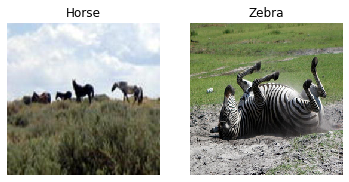

In [6]:
sample_horse = next(iter(horses))
sample_zebra = next(iter(zebras))

plt.subplot(1,2,1)
plt.imshow((sample_horse[0] + 1) / 2)
plt.title('Horse')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow((sample_zebra[0] + 1) / 2)
plt.title('Zebra')
plt.axis('off')

plt.show()

### Define generator and discriminator networks

In [0]:
def buildDiscriminator(image_shape):
  '''
  Build a 70x70 PatchGAN discriminator
  '''
  init = RandomNormal(stddev=0.02)
  input_img = Input(shape = image_shape)
  # C64 layer
  d = Conv2D(64, (4,4), strides = (2,2), padding = 'same', kernel_initializer=init)(input_img)
  d = LeakyReLU(0.2)(d)
  # C128 layer
  d = Conv2D(128, (4,4), strides = (2,2), padding = 'same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)
  # C256 layer
  d = Conv2D(256, (4,4), strides = (2,2), padding = 'same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)
  # C512 layer
  d = Conv2D(512, (4,4), strides = (2,2), padding = 'same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)
  # Output layer
  d_out = Conv2D(1, (4,4), padding = 'same', kernel_initializer=init)(d)

  disc = Model(input_img, d_out)

  return disc

In [0]:
def resnet_block(n_filters, input_layer):
  '''
  Build a resnet block with 2 convolutional layers, each with the same number of filters
  '''
  init = RandomNormal(stddev=0.02)
  r = Conv2D(n_filters, (3,3), padding = 'same', kernel_initializer=init)(input_layer)
  r = BatchNormalization()(r)
  r = ReLU()(r)

  r = Conv2D(n_filters, (3,3), padding = 'same', kernel_initializer=init)(r)
  r = BatchNormalization()(r)
  # concatenate output and input
  r = Concatenate()([r, input_layer])

  return r

In [0]:
def buildGenerator(image_shape, n_resnet=6):
  '''
  c7s1-64,d128,d256,R256,R256,R256,
  R256,R256,R256,u128,u64,c7s1-3
  '''
  init = RandomNormal(stddev=0.02)
  input_img = Input(shape = image_shape)
  # c7s1-64 layer
  g = Conv2D(64, (7,7), strides = (1,1), padding = 'same', kernel_initializer=init)(input_img)
  g = BatchNormalization()(g)
  g = ReLU()(g)
  # d128 layer
  g = Conv2D(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = ReLU()(g)
  # d256 layer
  g = Conv2D(256, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = ReLU()(g)
  # R256 layers
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  # u128 layer
  g = Conv2DTranspose(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = ReLU()(g)
  # u64 layer
  g = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = ReLU()(g)
  # c7s1-3 layer
  g = Conv2D(3, (7,7), strides = (1,1), padding = 'same', kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g_out = Activation('tanh')(g)

  generator = Model(input_img, g)

  return generator

### Define losses

In [0]:
mse_loss = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
  real_loss = mse_loss(tf.ones_like(real_output), real_output)
  fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss / 2.0

def generator_loss(fake_output):
  loss = mse_loss(tf.ones_like(fake_output), fake_output)
  return loss

def cycle_loss(original, cycled):
  loss = tf.reduce_mean(tf.abs(original - cycled))
  return LAMBDA * loss

def identity_loss(original, generated):
  loss = tf.reduce_mean(tf.abs(original - generated))
  return loss

### Training procedures

In [0]:
def update_image_pool(pool, images, max_size = 50):
  selected_imgs = list()
  for img in images:
    if len(pool) < max_size:
      pool.append(img)
      selected_imgs.append(img)
    elif random.random() < 0.5:
      selected_imgs.append(img)
    else:
      idx = random.randint(0, len(pool)-1)
      selected_imgs.append(pool[idx])
      pool[idx] = img

  return np.asarray(selected_imgs)

In [0]:
def train_step(real_H, real_Z):
  with tf.GradientTape(persistent=True) as tape:
    # Generator G goes H -> Z
    # Generator F goes Z -> H

    # Produce fake and cycled image samples
    fake_Z = generator_g(real_H, training = True)
    cycled_H = generator_f(fake_Z, training = True)

    fake_H = generator_f(real_Z, training = True)
    cycled_Z = generator_g(fake_H, training = True)

    # Select from history of generated images
    fake_H = update_image_pool(poolH, fake_H)
    fake_Z = update_image_pool(poolZ, fake_Z)

    # Produce image samples for identity loss
    same_H = generator_f(real_H, training = True)
    same_Z = generator_g(real_Z, training = True)

    # Use discriminators on generated and real images
    disc_real_H = discriminator_H(real_H, training = True)
    disc_fake_H = discriminator_H(fake_H, training = True)

    disc_real_Z = discriminator_Z(real_Z, training = True)
    disc_fake_Z = discriminator_Z(fake_Z, training = True)

    # Calculate losses
    gen_g_loss = generator_loss(disc_fake_Z)
    gen_f_loss = generator_loss(disc_fake_H)

    total_cycle_loss = cycle_loss(real_H, cycled_H) + cycle_loss(real_Z, cycled_Z)

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_Z, same_Z)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_H, same_H)

    disc_H_loss = discriminator_loss(disc_real_H, disc_fake_H)
    disc_Z_loss = discriminator_loss(disc_real_Z, disc_fake_Z)
  
  # Calculate gradients
  gen_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  gen_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  disc_H_gradients = tape.gradient(disc_H_loss, discriminator_H.trainable_variables)
  disc_Z_gradients = tape.gradient(disc_Z_loss, discriminator_Z.trainable_variables)

  # Apply gradients
  gen_g_optimizer.apply_gradients(zip(gen_g_gradients, generator_g.trainable_variables))
  gen_f_optimizer.apply_gradients(zip(gen_f_gradients, generator_f.trainable_variables))

  disc_H_optimizer.apply_gradients(zip(disc_H_gradients, discriminator_H.trainable_variables))
  disc_Z_optimizer.apply_gradients(zip(disc_Z_gradients, discriminator_Z.trainable_variables))

In [0]:
def progress_update(model, reverse_model, input_img, epoch, is_horse):
  prediction = model(test_input, training = False)
  cycled = reverse_model(prediction, training = False)

  display_list = [input_img[0], prediction[0], cycled[0]]
  titles = ['Original Image', 'Predicted Image', 'Cycled Image']

  plt.figure(figsize=(12,12))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.imshow(display_list[i] * 0.5 + 0.5) # scale images back from [-1,1] range to [0,1] for plotting
    plt.axis('off')

  if is_horse:
    plt.savefig('horse_imageAtEpoch{:04d}.png'.format(epoch))
  else:
    plt.savefig('zebra_imageAtEpoch{:04d}.png'.format(epoch))

  plt.show()

In [0]:
def train(dataA, dataB, n_epochs=100):
  sample_horse = next(iter(dataA))
  sample_zebra = next(iter(dataB))

  for epoch in range(n_epochs):
    start = time.time()
    print('Starting epoch {}'.format(epoch+1))

    n = 0
    for image_H, image_Z in tf.data.Dataset.zip((dataA, dataB)):
      train_step(image_H, image_Z)
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    print('Epoch {} time: {:.2f}'.format(epoch+1, time.time()-start))
    progress_update(generator_g, generator_f, sample_horse, epoch, is_horse=True)
    progress_update(generator_f, generator_g, sample_zebra, epoch, is_horse=False)
    display.clear_output(wait = True)

### Build it

In [0]:
input_shape = (256, 256, 3)

generator_g = buildGenerator(input_shape)
generator_f = buildGenerator(input_shape)

discriminator_H = buildDiscriminator(input_shape)
discriminator_Z = buildDiscriminator(input_shape)

LAMBDA = 10
gen_g_optimizer = Adam(lr = 0.0002, beta_1=0.5)
gen_f_optimizer = Adam(lr = 0.0002, beta_1=0.5)

disc_H_optimizer = Adam(lr = 0.0002, beta_1=0.5)
disc_Z_optimizer = Adam(lr = 0.0002, beta_1=0.5)

poolH, poolZ = list(), list()

train(horses, zebras)

Starting epoch 1
......